## PRÀCTICA 1 IDENTIFICACIÓ DE L'IDIOMA 
### Irene Pumares i Anna Casanovas

In [68]:
pip install nltk


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### 1. PREPROCESSAMENT DE LES DADES TRAIN

- Eliminació del dígits
- Passar tot el text a minúscula
- Substituir espais múltiples per un sol
- Substituir salts de línea per un espai doble

A més, s'ha aplicat l'eliminació de signes de puntuació ja que ajuda a la simplificació del text, reduint la seva complexitat, millorant la tokenització i eliminant soroll ja que tot i poder aparèixer amb frequència, no aporten informació substancial. 

In [4]:
import os
import re

def preprocess(texto): 
    '''
    Per cada document del train, apliquem el preprocessament. 
    '''
    texto = re.sub(r'\d', '', texto)        # Eliminem els dígits
    texto = texto.lower()                   # Convertim tot el text a minúscules
    texto = re.sub(r'[^\w\s]', '', texto)   # Eliminem els signes de puntuació
    texto = re.sub(r'\s+', ' ', texto)      # Substituim espais múltiples per un de sol
    texto = re.sub(r'\n', '  ', texto)      # Substituim els salts de línea per un espai doble
    return texto


def load_and_preprocess(file_path):
    '''
    Funció que s'encarrega de llegir tot el text del document per preprocessar-lo. 
    '''
    #print(file_path + " s'està llegint")
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    #print(file_path + ' s\'ha llegit')
    return preprocess(text)

languages = ['deu', 'eng', 'fra', 'nld', 'ita', 'spa'] # Llista de tots els llenguatges que el model sabrà identificar
training_data = {}                                     # Diccionari on per cada idioma, té un recompte de quants cops surt cada trigrama
text_inicial_train = {}                                # Diccionari on es guarda el text preprocessat de cada idioma

ruta_absoluta = 'C:/Users/irene/OneDrive/Escriptori/Pràctica 1 PLH'

#Per tots els llenguatges llegim i preprocessem les seves dades del train

for lang in languages:
    file_path = os.path.join(ruta_absoluta, f'{lang}_trn.txt')
    print('Processant:', file_path)
    if os.path.exists(file_path):
        text = load_and_preprocess(file_path)
        text_inicial_train[lang] = text
    else:
        print(f'L\'archiu {file_path} no existeix.')



Processant: /Users/annacasanovaspoirier/Desktop/IAA-lab/PRÀCTICA1/deu_trn.txt
Processant: /Users/annacasanovaspoirier/Desktop/IAA-lab/PRÀCTICA1/eng_trn.txt
Processant: /Users/annacasanovaspoirier/Desktop/IAA-lab/PRÀCTICA1/fra_trn.txt
Processant: /Users/annacasanovaspoirier/Desktop/IAA-lab/PRÀCTICA1/nld_trn.txt
Processant: /Users/annacasanovaspoirier/Desktop/IAA-lab/PRÀCTICA1/ita_trn.txt
Processant: /Users/annacasanovaspoirier/Desktop/IAA-lab/PRÀCTICA1/spa_trn.txt


### 2. CREACIÓ DEL MODEL A PARTIR DE TRIGRAMES I ENTRENAMENT

- Fer recompte del número de trigrames de caràcters
- Eliminació dels trigrames que apareixen menys de 5 cops
- Aplicació de tècnica de suavitzat
    - Llei de Laplace
    - Llei de Lidstone (LID)
        - Búsqueda de paràmetres i hiperparàmetres

Tècniques de suavitzat: 

Llei de Lidstone: (c_wi + lambda) / (N + lambda * B)

Després d'aplicar la llei de Laplace, s'ha vist que és millor fer servir la seva generalització que és la Llei de Lidstone. De la fòrmula mostrada:
- N representa el nombre de trigrames que hi ha al corpus
- V una aproximació del tamany del vocabulari únic en el corpus
- Lambda és un hiperparàmetre

V s'ha aproximat mirant el nombre de caràcters de cada idioma elevat al cub per fer totes les combinacions. Finalment, s'han obtingut millors resultats utilitzant la mitjana de tots els idiomes degut a una millor generalització. 

In [5]:
lam = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

In [6]:
'''Aquí definim els possibles valors que més tard serà elevat al cub són B'''
num_lletres = {'deu': 30, 'eng': 26, 'fra': 42, 'nld': 26, 'ita': 21, 'spa': 32}
mitjana_num_lletres = (30+26+42+26+21+32)/6

Recompte dels trigrames i càlcul de probabilitats

In [7]:
from nltk.collocations import TrigramCollocationFinder

def probabilitat_suavitzada(l, N, c):
    '''
    Calcula la probabilitat de cada trigrama amb el suavitzat de Lidstone
    '''

    p = (c + l)/((N)+(((29.5)**3)*l))
    return p

def entrenar_model(l):
    
    '''
    Donada una certa lambda, la funció troba els trigrames freqüents per cada llenguatge
    i omple un diccionari (trigrames_total) per obtenir les probabilitats per cada trigrama per cada idioma.
    '''

    languages = ['deu', 'eng', 'fra', 'nld', 'ita', 'spa']
    num_trigrams = {}                                                           # Nombre de trigrames que hi ha en general a cada corpus 
    #num_lletres = {'deu':30, 'eng':26, 'fra':42, 'nld':26, 'ita':21, 'spa':32}
    trigrames = {}                                                              # Per cada llengua tindrem el nombre de vegades que surt cada trigrama
    for lang in languages:
        finder = TrigramCollocationFinder.from_words(text_inicial_train[lang])
        finder.apply_freq_filter(5)                                             # Eliminem els trigrames que apareixen menys de 5 vegades
        trigrames[lang] = [tr for tr in finder.ngram_fd.items()]
        num_trigrams[lang] = sum(finder.ngram_fd.values())                      # N la calculem després de borrar els de menys de 5 (nombre d'unigrames totals)


    languages = ['deu', 'eng', 'fra', 'nld', 'ita', 'spa']
    trigrames_total = {}                                                        # Dicc per guardar les probabilitats de cada trigrama al seu idioma
    for language in languages:
        trigrames_total[language] = {}
        for trigram in trigrames[language]:
            trigrames_total[language][trigram[0]] = probabilitat_suavitzada(l,num_trigrams[language],trigram[1]) # Smoothing

    return l,trigrames_total,num_trigrams

In [9]:
from nltk.collocations import TrigramCollocationFinder

def preprocess_frase(texto):
    texto = re.sub(r'\d', '', texto)        # Elimina dígitos
    texto = texto.lower()                   # Convierte a minúscula
    texto = re.sub(r'[^\w\s]', '', texto)   # Elimina els signes de puntuació
    texto = re.sub(r'\s+', ' ', texto)      # Sustituye espacios múltiples por uno solo
    return texto

import math

def identificar_idioma(text,l,dicc,num_trigrams): 
    '''
    Funció que donada una frase identificarà el idioma del text basat en els trigrames.
    '''
    text = preprocess_frase(text)

    finder = TrigramCollocationFinder.from_words(text)
    trigrames = [tr for tr in finder.ngram_fd.items()]
    
    language_scores = {lang: 0 for lang in languages}

    for tri,freq in trigrames:
        for lang in languages:
            if tri in dicc[lang]:
                language_scores[lang] += dicc[lang][tri]*freq
            else:
                language_scores[lang] += (probabilitat_suavitzada(l,num_trigrams[lang],0))*freq
    
    log_language_scores = {lang: math.log(score) for lang, score in language_scores.items() if score > 0}
    
    return str(max(log_language_scores, key=log_language_scores.get))


### 3. PREPROCESSAMENT DE LES DADES TEST I PREDICCIÓ

Com anteriorment hem fet un cross-validation per aconseguir la lambda millor, li donem com a paràmetre 
0.1 a la funció entrenar model, també fem un preprocessament i finalment fem les prediccions. 

In [10]:
import os
import re

def preprocess_test(text):
    text = re.sub(r'\d', '', text)           # Elimina dígits
    text = text.lower()                      # Passa a minúscula
    lineas = text.split('\n')                # Divideix el text en una llista de strings per cada salt de pàgina
    lineas_final = [linea.strip() for linea in lineas if linea.strip()]  # Elimina lineas buides i espais extra
    return lineas_final

def load_and_preprocess_test(file_path, language):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()

    return preprocess_test(text), [language] * len(preprocess_test(text))

directory_path = 'C:/Users/irene/OneDrive/Escriptori/Pràctica 1 PLH' #Directori on són les dades

languages = ['deu', 'eng', 'fra', 'nld', 'ita', 'spa']
text_processed_list = []                            # Llista amb les frases del test

y_true = []                                         # Llista de les etiquetes de veritat de la partició del test
y_pred = []                                         # Llista de les etiquetes que el model prediu

lam, diccio, num_trigrames = entrenar_model(0.1)    # Entrenem el model aplicant un suavitzat de lambda 1

for language in languages:
    file_name = language + '_tst.txt'
    file_path = os.path.join(directory_path, file_name)
    
    if os.path.exists(file_path):
        text_processed, labels = load_and_preprocess_test(file_path, language)  # Fem el preprocessament
        text_processed_list.extend(text_processed)
        y_true.extend(labels)                                                   # Apuntem les etiquetes
        
        for frase in text_processed:
            y_pred.append(identificar_idioma(frase, lam, diccio,num_trigrames)) # Fem la predicció
    else:
        print(f'Arxiu {file_path} no existeix.')

total_ben_fetes = sum(1 for true, pred in zip(y_true, y_pred) if true == pred)
percentatge = total_ben_fetes / len(y_pred) * 100
print(f'Percentatge de mostres identificades correctament: {percentatge}%')


/Users/annacasanovaspoirier/Desktop/IAA-lab/PRÀCTICA1/deu_tst.txt leyendo
/Users/annacasanovaspoirier/Desktop/IAA-lab/PRÀCTICA1/deu_tst.txt se ha leído
/Users/annacasanovaspoirier/Desktop/IAA-lab/PRÀCTICA1/eng_tst.txt leyendo
/Users/annacasanovaspoirier/Desktop/IAA-lab/PRÀCTICA1/eng_tst.txt se ha leído
/Users/annacasanovaspoirier/Desktop/IAA-lab/PRÀCTICA1/fra_tst.txt leyendo
/Users/annacasanovaspoirier/Desktop/IAA-lab/PRÀCTICA1/fra_tst.txt se ha leído
/Users/annacasanovaspoirier/Desktop/IAA-lab/PRÀCTICA1/nld_tst.txt leyendo
/Users/annacasanovaspoirier/Desktop/IAA-lab/PRÀCTICA1/nld_tst.txt se ha leído
/Users/annacasanovaspoirier/Desktop/IAA-lab/PRÀCTICA1/ita_tst.txt leyendo
/Users/annacasanovaspoirier/Desktop/IAA-lab/PRÀCTICA1/ita_tst.txt se ha leído
/Users/annacasanovaspoirier/Desktop/IAA-lab/PRÀCTICA1/spa_tst.txt leyendo
/Users/annacasanovaspoirier/Desktop/IAA-lab/PRÀCTICA1/spa_tst.txt se ha leído
Porcentaje de identificación correcta: 98.18263667739299%


La lambda anterior s'ha escollit utilitzant un cross validation provant valors entre 0.1 i 1 amb el codi següent:

In [93]:
from sklearn.model_selection import KFold
from collections import Counter
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=1)                # Configurem 5 folds per ver cross validation

lam_values = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1] # Li donem la llista de valors a probar

best_lambda = None
best_accuracy = 0

for l in lam_values:
    accuracies = []                                                 # Emmagatzemem les precisions per a cada lambda
    

    for train_index, test_index in kf.split(text_processed_list):

        # Creem el conjunt d'entrenament i el de prova
        X_train, X_test = [text_processed_list[i] for i in train_index], [text_processed_list[i] for i in test_index]
        y_train, y_test = [y_true[i] for i in train_index], [y_true[i] for i in test_index]
        
        # Entrenem el model amb la lambda actual
        _, trained_model, num_trigrams = entrenar_model(l)
        
        # Fem les prediccions
        y_pred = [identificar_idioma(text, l, trained_model, num_trigrams) for text in X_test]
        
        # Calculem la precisió
        accuracy = sum(1 for true, pred in zip(y_test, y_pred) if true == pred) / len(y_pred)
        accuracies.append(accuracy)
    
    average_accuracy = np.mean(accuracies)
    
    # Escollim la de millor precisió
    if average_accuracy > best_accuracy:
        best_accuracy = average_accuracy
        best_lambda = l

    print(f"Lambda: {l}, Precisió mitjana del cross-validation: {average_accuracy}")

print(f"El millor valor de lambda és {best_lambda} amb una precisió de {best_accuracy}")


Lambda: 0.05, Precisión media de CV: 0.9814095528021637
Lambda: 0.1, Precisión media de CV: 0.9814095528021637


### 4. RESULTATS I ANÀLISI

Un cop tenim hem fet el test veiem els resultats. 

Veiem la matriu de confusió

In [11]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_true, y_pred)
print(f'Matriu de confusió: \n{conf_matrix}')

Matriu de confusió: 
[[9825   19   37    7   93    9]
 [  61 9678  109   28   88   23]
 [  40   13 9768   22   98   59]
 [   7    4   34 9853    7   95]
 [  51   16   18    2 9907    6]
 [  20    3   36   58   27 9856]]


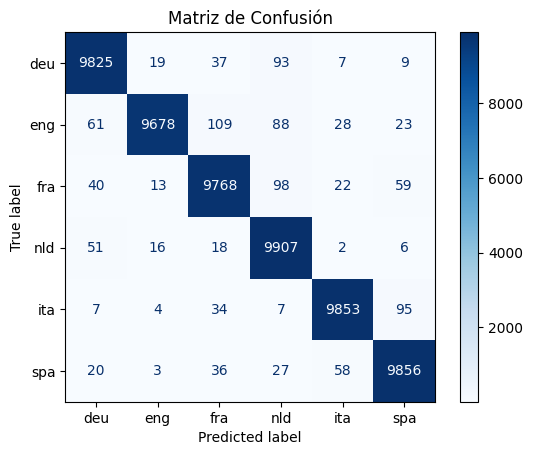

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred, labels=["deu", "eng", "fra", "nld", "ita", "spa"])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["deu", "eng", "fra", "nld", "ita", "spa"])
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión')
plt.show()


Fem una anàlisi extensa també de la precisió, el recall i el f1 i f2-score

In [13]:
from sklearn.metrics import accuracy_score, recall_score, fbeta_score, classification_report

accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy}')

recall = recall_score(y_true, y_pred, average=None, labels=["deu", "eng", "fra", "nld", "ita", "spa"])
f2_score = fbeta_score(y_true, y_pred, beta=2, average=None, labels=["deu", "eng", "fra", "nld", "ita", "spa"])

for i, language in enumerate(["deu", "eng", "fra", "nld", "ita", "spa"]):
    print(f'{language} - Recall: {recall[i]}, F2-Score: {f2_score[i]}')

print()

print(classification_report(y_true, y_pred, target_names=["deu", "eng", "fra", "nld", "ita", "spa"]))


Accuracy: 0.98182636677393
deu - Recall: 0.9834834834834835, F2-Score: 0.9832079096949805
eng - Recall: 0.9690597777110244, F2-Score: 0.9740142106640367
fra - Recall: 0.9768, F2-Score: 0.9767609295628175
nld - Recall: 0.9907, F2-Score: 0.9863600159299083
ita - Recall: 0.9853, F2-Score: 0.9858915349209524
spa - Recall: 0.9856, F2-Score: 0.9846547314578006

              precision    recall  f1-score   support

         deu       0.98      0.98      0.98      9990
         eng       0.99      0.97      0.98      9987
         fra       0.98      0.98      0.98     10000
         nld       0.99      0.99      0.99     10000
         ita       0.97      0.99      0.98     10000
         spa       0.98      0.99      0.98     10000

    accuracy                           0.98     59977
   macro avg       0.98      0.98      0.98     59977
weighted avg       0.98      0.98      0.98     59977

